In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

Text(0, 0.5, 'Utility / happiness (normalized)')

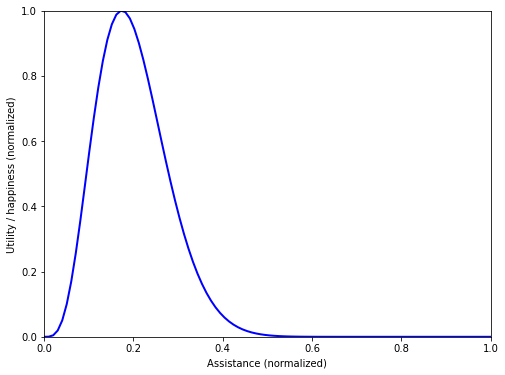

In [3]:
x = np.linspace(0, 1, 100)
U = stats.beta.pdf(x, 5, 20)
U = U / np.max(U)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(x, U, 'b-', lw = 2, label = 'Utility')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Assistance (normalized)')
ax.set_ylabel('Utility / happiness (normalized)')

Text(0, 0.5, 'Probability density')

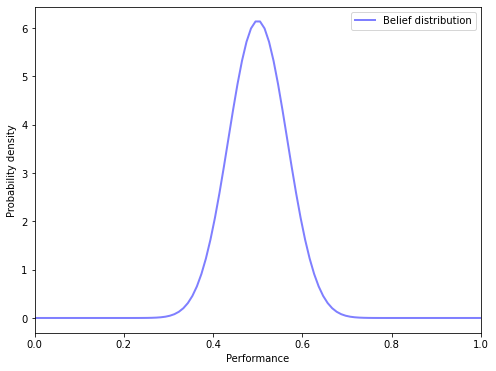

In [4]:
x = np.linspace(0, 1, 100)
p = stats.beta.pdf(x, 30, 30)
# U = U / np.max(U)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(x, p, 'b-', lw = 2, label = 'Belief distribution', alpha = 0.5)
ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel('Performance')
ax.set_ylabel('Probability density')

Text(0, 0.5, 'Probability density')

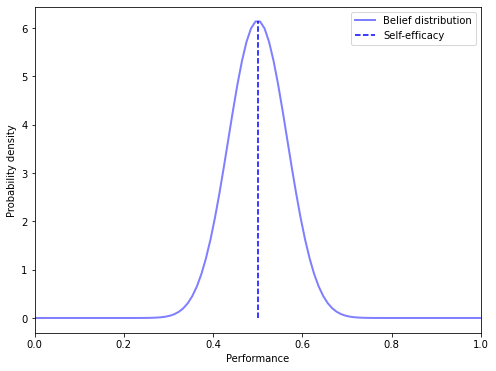

In [5]:
x = np.linspace(0, 1, 100)
p = stats.beta.pdf(x, 30, 30)
self_efficacy = 30 / (30 + 30)
# U = U / np.max(U)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(x, p, 'b-', lw = 2, label = 'Belief distribution', alpha = 0.5)
ax.vlines(self_efficacy, 0, np.max(p), color = 'b', linestyles='dashed', label = 'Self-efficacy')    
ax.set_xlim(0, 1)
ax.legend()
ax.set_xlabel('Performance')
ax.set_ylabel('Probability density')

Text(0, 0.5, 'Probability density')

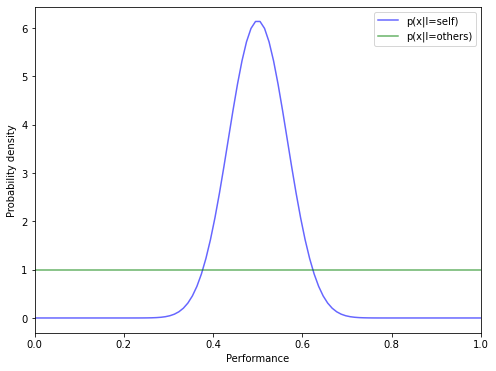

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
likelihood_self = stats.beta.pdf(x, 30, 30)
likelihood_others = stats.uniform.pdf(x)
plt.plot(x, likelihood_self, 'b-', alpha=0.6, label='p(x|I=self)')
plt.plot(x, likelihood_others, 'g-', alpha=0.6, label='p(x|I=others)')
plt.legend()
ax.set_xlim(0, 1)
plt.xlabel('Performance')
plt.ylabel('Probability density')


Text(0, 0.5, 'Probability')

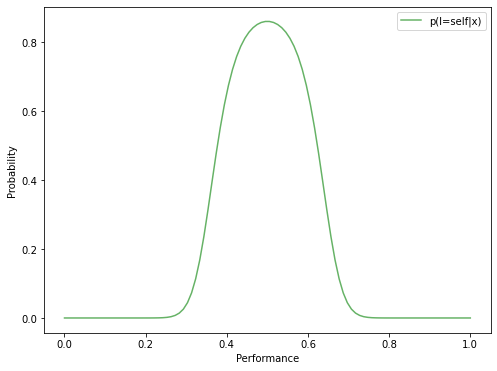

In [8]:
prior_self, prior_others = 0.5, 0.5
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
posterior_self = likelihood_self * prior_self / (likelihood_self * prior_self + likelihood_others * prior_others)
posterior_others = 1 - posterior_self
plt.plot(x, posterior_self, 'g-', alpha=0.6, label='p(I=self|x)')
plt.legend()
plt.xlabel('Performance')
plt.ylabel('Probability')

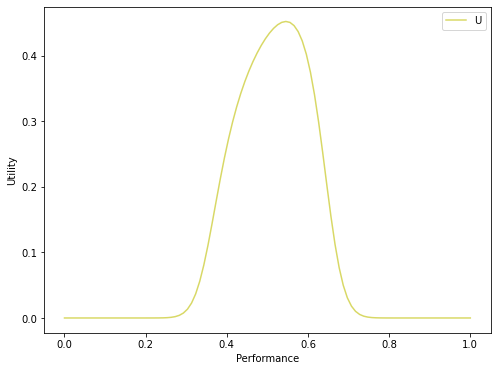

In [9]:
gamma_self = 1
gamma_others = 0
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
U = posterior_self * gamma_self * x + posterior_others * gamma_others * x
plt.plot(x, U, 'y-', alpha=0.6, label='U')
plt.legend()
plt.xlabel('Performance')
plt.ylabel('Utility')
plt.show()

c:\Project\Moonshot_self_efficacy\BayesianIntrinsicReward\utils.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 576x432 with 1 Axes>,
 <Axes: xlabel='Performance', ylabel='Utility'>)

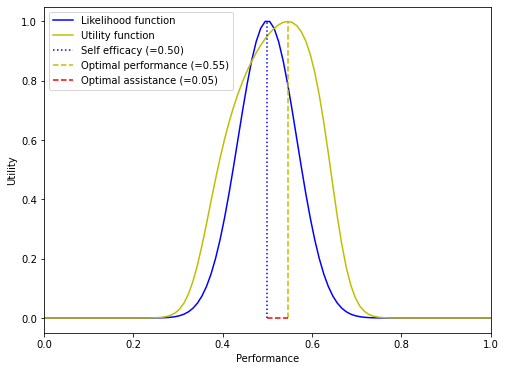

In [10]:
from utils import Agent_BayesianDecision
Agent_BayesianDecision(30, 30).plot_utility()

C:\Users\acerc\AppData\Local\Temp\ipykernel_12552\2066793059.py:100: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 576x432 with 1 Axes>,
 <Axes: xlabel='Performance', ylabel='Utility'>)

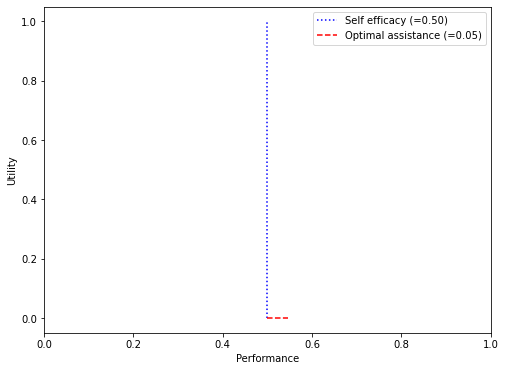

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

class Agent:
    pass

class Agent_BayesianDecision(Agent):
    def __init__(self, alpha, beta, p_self=0.5, p_others=0.5, gamma_self=1, gamma_others=0):
        self.alpha = alpha
        self.beta = beta
        self.p_self = p_self
        self.p_others = p_others
        self.gamma_self = gamma_self
        self.gamma_others = gamma_others
        
    def likelihood_self(self):
        # likelihood of the performance given self as the cause
        return stats.beta(self.alpha, self.beta)

    def likelihood_others(self):
        # likelihood of the performance given others as the cause
        return stats.uniform(0, 1)
        
    def posterior(self, x):
        # likelihood of the performance given self as the cause
        p_x_given_self = self.likelihood_self().logpdf(x)

        # likelihood of the performance given others as the cause
        p_x_given_others = self.likelihood_others().logpdf(x)

        # Compute log posterior belief of the cause of the performance
        p_self_given_x_ = (
            np.log(self.p_self) + 
            p_x_given_self - 
            np.logaddexp(np.log(self.p_self) + p_x_given_self,
                         np.log(self.p_others) + p_x_given_others)
            )
        p_self_given_x = np.exp(p_self_given_x_)
        p_others_given_x = 1 - p_self_given_x
        return p_self_given_x, p_others_given_x
    
    def Utility(self, x):
        # Utility function
        p_self_given_x, p_others_given_x = self.posterior(x)
        U_self = self.gamma_self * p_self_given_x * x
        U_others = self.gamma_others * p_others_given_x * x
        U = U_self + U_others
        return U
    
    def self_efficacy(self):
        # self efficacy: mean of the likelihood of the performance given self as the cause
        return self.alpha / (self.alpha + self.beta)
    
    def find_optimal_performance(self):
        # find the optimal performance
        res = minimize(lambda x: -self.Utility(x), 0.5, method='nelder-mead')
        return res.x[0]
    
    def find_optimal_assistance(self):
        # find the optimal assistance
        a_opt = self.find_optimal_performance() - self.self_efficacy()
        return a_opt
    
    def plot_utility(self, fig=None, ax=None):
        x = np.linspace(0, 1, 100)
        
        # likelihood of the performance given self as the cause
        p = self.likelihood_self().pdf(x)
        p = p / np.max(p)
        se = self.self_efficacy()

        # utility function
        U = self.Utility(x)
        U = U / np.max(U)
        
        # optimal performance
        x_opt = self.find_optimal_performance()
        a_opt = x_opt - self.self_efficacy()

        if fig is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        # ax.plot(x, p, 'b-', label='Likelihood function')
        # ax.plot(x, U, 'y-', label='Utility function')
        ax.vlines(se, 0, 1, 
                  linestyles='dotted', color='b',
                  label=f'Self efficacy (={se:.2f})')
        # ax.vlines(x_opt, 0, 1, 
        #           linestyles='dashed', color='y',
        #           label=f'Optimal performance (={x_opt:.2f})')
        # plot the optimal assistance
        ax.hlines(0, se, x_opt, 
              linestyles='dashed', color='r',
              label=f'Optimal assistance (={a_opt:.2f})')
        ax.set_xlabel('Performance')
        ax.set_ylabel('Utility')
        ax.set_xlim([0, 1])
        ax.legend()
        fig.show()
        return fig, ax
    
Agent_BayesianDecision(30, 30).plot_utility()  

Text(0, 0.5, 'Probability density')

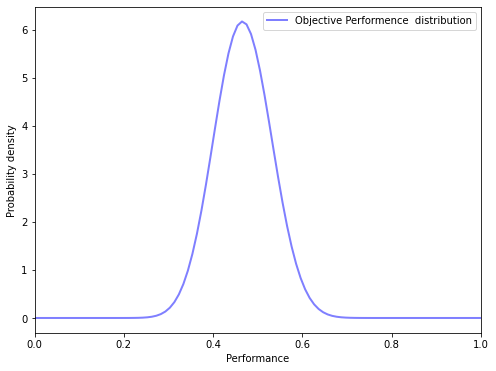

In [16]:
x = np.linspace(0, 1, 100)
p = stats.beta.pdf(x, 28, 32)
# U = U / np.max(U)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(x, p, 'b-', lw = 2, label = 'Objective Performence  distribution', alpha = 0.5)
ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel('Performance')
ax.set_ylabel('Probability density')

Text(0, 0.5, 'Probability density')

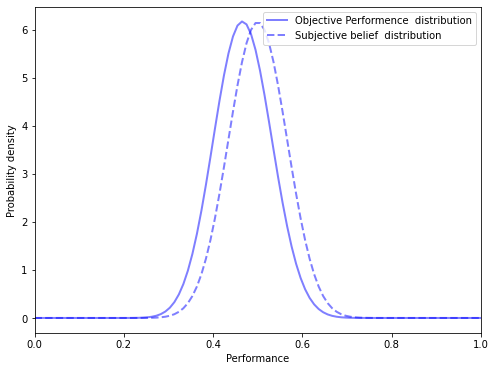

In [17]:
x = np.linspace(0, 1, 100)
p = stats.beta.pdf(x, 28, 32)
p_ = stats.beta.pdf(x, 30, 30)
# U = U / np.max(U)
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(x, p, 'b-', lw = 2, label = 'Objective Performence  distribution', alpha = 0.5)
ax.plot(x, p_, 'b--', lw = 2, label = 'Subjective belief  distribution', alpha = 0.5)
ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
ax.legend()
ax.set_xlabel('Performance')
ax.set_ylabel('Probability density')

C:\Users\acerc\AppData\Local\Temp\ipykernel_12552\2306282993.py:46: RuntimeWarning: invalid value encountered in subtract
  np.log(self.p_self) +
C:\Users\acerc\AppData\Local\Temp\ipykernel_12552\2306282993.py:111: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 576x432 with 1 Axes>,
 <Axes: xlabel='Performance', ylabel='Utility'>)

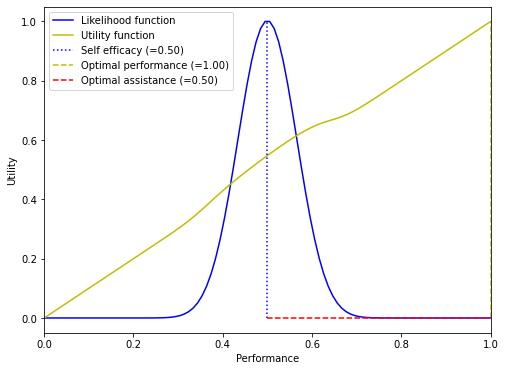

In [20]:
# %% 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize

from model import model
import numpyro
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import jax.random as random
import jax.numpy as jnp
import arviz as az



class Agent:
    pass

class Agent_BayesianDecision(Agent):
    def __init__(self, alpha, beta, p_self=0.5, p_others=0.5, gamma_self=1, gamma_others=0):
        self.alpha = alpha
        self.beta = beta
        self.p_self = p_self
        self.p_others = p_others
        self.gamma_self = gamma_self
        self.gamma_others = gamma_others
        
    def likelihood_self(self):
        # likelihood of the performance given self as the cause
        return stats.beta(self.alpha, self.beta)

    def likelihood_others(self):
        # likelihood of the performance given others as the cause
        return stats.uniform(0, 1)
        
    def posterior(self, x):
        # likelihood of the performance given self as the cause
        p_x_given_self = self.likelihood_self().logpdf(x)

        # likelihood of the performance given others as the cause
        p_x_given_others = self.likelihood_others().logpdf(x)

        # Compute log posterior belief of the cause of the performance
        p_self_given_x_ = (
            np.log(self.p_self) + 
            p_x_given_self - 
            np.logaddexp(np.log(self.p_self) + p_x_given_self,
                         np.log(self.p_others) + p_x_given_others)
            )
        p_self_given_x = np.exp(p_self_given_x_)
        p_others_given_x = 1 - p_self_given_x
        return p_self_given_x, p_others_given_x
    
    def Utility(self, x):
        # Utility function
        p_self_given_x, p_others_given_x = self.posterior(x)
        U_self = self.gamma_self * p_self_given_x * x
        U_others = self.gamma_others * p_others_given_x * x
        U = U_self + U_others
        return U
    
    def self_efficacy(self):
        # self efficacy: mean of the likelihood of the performance given self as the cause
        return self.alpha / (self.alpha + self.beta)
    
    def find_optimal_performance(self):
        # find the optimal performance
        res = minimize(lambda x: -self.Utility(x), 0.5, method='nelder-mead')
        return res.x[0]
    
    def find_optimal_assistance(self):
        # find the optimal assistance
        a_opt = self.find_optimal_performance() - self.self_efficacy()
        return a_opt
    
    def plot_utility(self, fig=None, ax=None):
        x = np.linspace(0, 1, 100)
        
        # likelihood of the performance given self as the cause
        p = self.likelihood_self().pdf(x)
        p = p / np.max(p)
        se = self.self_efficacy()

        # utility function
        U = self.Utility(x)
        U = U / np.max(U)
        
        # optimal performance
        x_opt = self.find_optimal_performance()
        a_opt = x_opt - self.self_efficacy()

        if fig is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        ax.plot(x, p, 'b-', label='Likelihood function')
        ax.plot(x, U, 'y-', label='Utility function')
        ax.vlines(se, 0, 1, 
                  linestyles='dotted', color='b',
                  label=f'Self efficacy (={se:.2f})')
        ax.vlines(x_opt, 0, 1, 
                  linestyles='dashed', color='y',
                  label=f'Optimal performance (={x_opt:.2f})')
        # plot the optimal assistance
        ax.hlines(0, se, x_opt, 
              linestyles='dashed', color='r',
              label=f'Optimal assistance (={a_opt:.2f})')
        ax.set_xlabel('Performance')
        ax.set_ylabel('Utility')
        ax.set_xlim([0, 1])
        ax.legend()
        fig.show()
        return fig, ax

Agent_BayesianDecision(30, 30, p_self=0.5, p_others=0.5, gamma_self=1, gamma_others=0.9).plot_utility()